# NBA Shots Dataset Cleaning and Preprocessing

This notebook outlines the comprehensive steps taken to clean and preprocess the NBA shots dataset, spanning the years 2019 to 2023. The dataset encompasses a wide array of features related to shots taken during NBA games, including player and team information, shot positions, and game contexts. The initial phase of cleaning ensures the data is accurate and free of anomalies, while the subsequent preprocessing phase transforms the data into a structured format, suitable for exploratory data analysis and machine learning modeling.

## Setup

Import necessary libraries and configure the environment for the data cleaning and preprocessing tasks.


In [466]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Data Loading

Load the NBA shots data from CSV files for the years 2019 to 2023 and combine them into a single DataFrame.

In [467]:
years = [2019, 2020, 2021, 2022, 2023]
dfs = {'combined': pd.DataFrame()}  # Initialize a combined DataFrame

for year in years:
    file_path = f"data/NBA_{year}_Shots.csv"
    try:
        df = pd.read_csv(file_path)
        dfs[year] = df  # Store the DataFrame in the dictionary
        dfs['combined'] = pd.concat([dfs['combined'], df], ignore_index=True)  # Update the combined DataFrame
    except FileNotFoundError:
        print(f"The file 'NBA_{year}_Shots.csv' for {year} does not exist.")


# To select a specific year (e.g., 2020), you can access it like this:

df2019 = dfs[2019]
df2020 = dfs[2020]
df2021 = dfs[2021]
df2022 = dfs[2022]
df2023 = dfs[2023]

# To select the combined data, you can access it like this:
dfcombined = dfs['combined']

In [468]:
 df2015 = pd.read_csv("data/NBA_2015_Shots.csv")

## Data Cleaning

Identify and handle missing values in the dataset to ensure data quality for analysis.


In [469]:
# Check for missing values in each column
missing_values = dfcombined.isnull().sum()
missing_values_2015 = df2015.isnull().sum()
# Print columns with missing values and their respective counts


In [470]:
# Handling missing values: Check the percentage of missing values in 'POSITION_GROUP' and 'POSITION'
missing_values_percentage = dfcombined[['POSITION_GROUP', 'POSITION']].isnull().mean() * 100

# Handling duplicate rows: Check for any duplicate rows in the data
duplicate_rows = dfcombined.duplicated().sum()

# Output the percentage of missing values and the number of duplicate rows
(missing_values_percentage, duplicate_rows)

(POSITION_GROUP    0.513802
 POSITION          0.513802
 dtype: float64,
 60)

In [471]:
# Handling missing values: Check the percentage of missing values in 'POSITION_GROUP' and 'POSITION'
missing_values_percentage_2015 = df2015[['POSITION_GROUP', 'POSITION']].isnull().mean() * 100

# Handling duplicate rows: Check for any duplicate rows in the data
duplicate_rows_2015 = df2015.duplicated().sum()

# Output the percentage of missing values and the number of duplicate rows
(missing_values_percentage_2015, duplicate_rows_2015)

(POSITION_GROUP    0.055461
 POSITION          0.055461
 dtype: float64,
 0)

In [472]:
# Detect outliers using Z-score

# Outlier detection for 'LOC_X'
z_scores_loc_x = np.abs(stats.zscore(dfcombined['LOC_X']))
outliers_loc_x = np.where(z_scores_loc_x > 3)


# Outlier detection for 'LOC_Y'
z_scores_loc_y = np.abs(stats.zscore(dfcombined['LOC_Y']))
outliers_loc_y = np.where(z_scores_loc_y > 3)


# Outlier detection for 'SHOT_DISTANCE'
z_scores_shot_distance = np.abs(stats.zscore(dfcombined['SHOT_DISTANCE']))
outliers_shot_distance = np.where(z_scores_shot_distance > 3)


In [473]:
# Detect outliers using Z-score

# Outlier detection for 'LOC_X'
z_scores_loc_x_2015 = np.abs(stats.zscore(df2015['LOC_X']))
outliers_loc_x_2015 = np.where(z_scores_loc_x_2015 > 3)


# Outlier detection for 'LOC_Y'
z_scores_loc_y_2015 = np.abs(stats.zscore(df2015['LOC_Y']))
outliers_loc_y_2015 = np.where(z_scores_loc_y_2015 > 3)


# Outlier detection for 'SHOT_DISTANCE'
z_scores_shot_distance_2015 = np.abs(stats.zscore(df2015['SHOT_DISTANCE']))
outliers_shot_distance_2015 = np.where(z_scores_shot_distance_2015 > 3)

In [474]:
# Identify unique player names associated with each player ID
player_id_name = dfcombined.groupby('PLAYER_ID')['PLAYER_NAME'].unique()

# Identify player IDs with more than one associated name
inconsistent_players = player_id_name[player_id_name.apply(len) > 1]

# Identify unique team names associated with each team ID
team_id_name = dfcombined.groupby('TEAM_ID')['TEAM_NAME'].unique()

# Identify team IDs with more than one associated name
inconsistent_teams = team_id_name[team_id_name.apply(len) > 1]


In [475]:
# Identify unique player names associated with each player ID
player_id_name_2015 = df2015.groupby('PLAYER_ID')['PLAYER_NAME'].unique()

# Identify player IDs with more than one associated name
inconsistent_players_2015 = player_id_name_2015[player_id_name_2015.apply(len) > 1]

# Identify unique team names associated with each team ID
team_id_name_2015 = df2015.groupby('TEAM_ID')['TEAM_NAME'].unique()

# Identify team IDs with more than one associated name
inconsistent_teams_2015 = team_id_name_2015[team_id_name_2015.apply(len) > 1]

In [476]:
# Drop the duplicate rows
dfcombined_cleaned = dfcombined.drop_duplicates()

# Since the percentage of missing values is small, we will drop the rows with missing 'POSITION_GROUP' and 'POSITION'
dfcombined_cleaned = dfcombined_cleaned.dropna(subset=['POSITION_GROUP', 'POSITION'])

# Corrections for player names
player_name_corrections = {
    1630197: "Aleksej Pokusevski",
    1630527: "Brandon Boston Jr.",
    1628408: "PJ Dozier",
    1628384: "OG Anunoby",
    1630214: "Xavier Tillman Sr.",
    1630288: "Jeff Dowtin Jr."
}

# Apply the corrections for player names
dfcombined_cleaned['PLAYER_NAME'] = dfcombined_cleaned.apply(lambda row: player_name_corrections[row['PLAYER_ID']] if row['PLAYER_ID'] in player_name_corrections else row['PLAYER_NAME'], axis=1)

# Corrections for team names
team_name_corrections = {
    "LA Clippers": "Los Angeles Clippers"
}

# Apply the corrections for team names
dfcombined_cleaned['TEAM_NAME'] = dfcombined_cleaned['TEAM_NAME'].replace(team_name_corrections)

In [477]:
# Drop the duplicate rows
dfcombined_cleaned_2015 = df2015.drop_duplicates()

# Since the percentage of missing values is small, we will drop the rows with missing 'POSITION_GROUP' and 'POSITION'
dfcombined_cleaned_2015 = dfcombined_cleaned_2015.dropna(subset=['POSITION_GROUP', 'POSITION'])

# Corrections for player names
player_name_corrections_2015 = {
    1630197: "Aleksej Pokusevski",
    1630527: "Brandon Boston Jr.",
    1628408: "PJ Dozier",
    1628384: "OG Anunoby",
    1630214: "Xavier Tillman Sr.",
    1630288: "Jeff Dowtin Jr."
}

# Apply the corrections for player names
dfcombined_cleaned_2015['PLAYER_NAME'] = dfcombined_cleaned_2015.apply(lambda row: player_name_corrections_2015[row['PLAYER_ID']] if row['PLAYER_ID'] in player_name_corrections_2015 else row['PLAYER_NAME'], axis=1)

# Corrections for team names
team_name_corrections_2015 = {
    "LA Clippers": "Los Angeles Clippers"
}

# Apply the corrections for team names
dfcombined_cleaned_2015['TEAM_NAME'] = dfcombined_cleaned_2015['TEAM_NAME'].replace(team_name_corrections_2015)

## Data Preprocessing

##### Feature Description

Before transforming our features to be suitable for machine learning algorithms, let's summarize the characteristics of our numeric and categorical variables post-cleaning:

In [478]:
# Mapping Players & Teams with their IDs and zone names with its abbreviaton 

# Extract unique team IDs
unique_team_ids = dfcombined_cleaned['TEAM_ID'].unique()

# Extract unique team names
unique_team_names = dfcombined_cleaned['TEAM_NAME'].unique()

# Extract unique team abbreviations from the 'HOME_TEAM' column
unique_home_teams = dfcombined_cleaned['HOME_TEAM'].unique()

# Extract unique player IDs
unique_player_ids = dfcombined_cleaned['PLAYER_ID'].unique()

# Extract unique player names
unique_player_names = dfcombined_cleaned['PLAYER_NAME'].unique()

# Extract unique zone names
unique_zone_names = dfcombined_cleaned['ZONE_NAME'].unique()

# Extract unique zone abbreviations
unique_zone_abb = dfcombined_cleaned['ZONE_ABB'].unique()

In [479]:
# Mapping Players & Teams with their IDs and zone names with its abbreviaton 

# Extract unique team IDs
unique_team_ids_2015 = dfcombined_cleaned_2015['TEAM_ID'].unique()

# Extract unique team names
unique_team_names_2015 = dfcombined_cleaned_2015['TEAM_NAME'].unique()

# Extract unique team abbreviations from the 'HOME_TEAM' column
unique_home_teams_2015 = dfcombined_cleaned_2015['HOME_TEAM'].unique()

# Extract unique player IDs
unique_player_ids_2015 = dfcombined_cleaned_2015['PLAYER_ID'].unique()

# Extract unique player names
unique_player_names_2015 = dfcombined_cleaned_2015['PLAYER_NAME'].unique()

# Extract unique zone names
unique_zone_names_2015 = dfcombined_cleaned_2015['ZONE_NAME'].unique()

# Extract unique zone abbreviations
unique_zone_abb_2015 = dfcombined_cleaned_2015['ZONE_ABB'].unique()

In [480]:
# Creating a Is_Home_Team binary column in order to not double count the home/away feature and making it a numerical to save 
# memory + easier for future usage

# Mapping dictionaries to convert team, player identifiers and zone names to names and abbreviations.
team_id_to_name_mapping = dict(zip(unique_team_ids, unique_team_names))
team_abbreviation_to_id_mapping = dict(zip(unique_home_teams, unique_team_ids))
player_id_to_name_mapping = dict(zip(unique_player_ids, unique_player_names))
zone_abb_to_zonename_mapping = dict(zip(unique_zone_abb, unique_zone_names))

# Mapping team abbreviations to numeric team IDs for the 'HOME_TEAM' column.
team_abbr_to_id = {
    'LAC': 1610612762, 'ATL': 1610612746, 'MIL': 1610612737,
    'BKN': 1610612754, 'SAS': 1610612760, 'MEM': 1610612749,
    'NYK': 1610612751, 'PHI': 1610612748, 'DEN': 1610612742,
    'CHA': 1610612759, 'POR': 1610612744, 'DAL': 1610612752,
    'UTA': 1610612763, 'MIA': 1610612765, 'OKC': 1610612741,
    'LAL': 1610612750, 'DET': 1610612755, 'WAS': 1610612743,
    'MIN': 1610612766, 'NOP': 1610612753, 'CHI': 1610612758,
    'CLE': 1610612757, 'GSW': 1610612756, 'TOR': 1610612745,
    'SAC': 1610612747, 'BOS': 1610612764, 'HOU': 1610612738,
    'IND': 1610612761, 'ORL': 1610612740, 'PHX': 1610612739
}

# Apply the mapping to the 'HOME_TEAM' column to create a 'Home_Team_ID' column.
dfcombined_cleaned['Home_Team_ID'] = dfcombined_cleaned['HOME_TEAM'].map(team_abbr_to_id)

# Determine if the team is playing at home and encode this in a new 'Is_Home_Team' column.
dfcombined_cleaned['IS_HOME_TEAM'] = (dfcombined_cleaned['Home_Team_ID'] == dfcombined_cleaned['TEAM_ID']).astype(int)

In [481]:
# Creating a Is_Home_Team binary column in order to not double count the home/away feature and making it a numerical to save 
# memory + easier for future usage

# Mapping dictionaries to convert team, player identifiers and zone names to names and abbreviations.
team_id_to_name_mapping_2015 = dict(zip(unique_team_ids_2015, unique_team_names_2015))
team_abbreviation_to_id_mapping_2015 = dict(zip(unique_home_teams_2015, unique_team_ids_2015))
player_id_to_name_mapping_2015 = dict(zip(unique_player_ids_2015, unique_player_names_2015))
zone_abb_to_zonename_mapping_2015 = dict(zip(unique_zone_abb_2015, unique_zone_names_2015))

# Mapping team abbreviations to numeric team IDs for the 'HOME_TEAM' column.
team_abbr_to_id_2015 = {
    'LAC': 1610612762, 'ATL': 1610612746, 'MIL': 1610612737,
    'BKN': 1610612754, 'SAS': 1610612760, 'MEM': 1610612749,
    'NYK': 1610612751, 'PHI': 1610612748, 'DEN': 1610612742,
    'CHA': 1610612759, 'POR': 1610612744, 'DAL': 1610612752,
    'UTA': 1610612763, 'MIA': 1610612765, 'OKC': 1610612741,
    'LAL': 1610612750, 'DET': 1610612755, 'WAS': 1610612743,
    'MIN': 1610612766, 'NOP': 1610612753, 'CHI': 1610612758,
    'CLE': 1610612757, 'GSW': 1610612756, 'TOR': 1610612745,
    'SAC': 1610612747, 'BOS': 1610612764, 'HOU': 1610612738,
    'IND': 1610612761, 'ORL': 1610612740, 'PHX': 1610612739
}

# Apply the mapping to the 'HOME_TEAM' column to create a 'Home_Team_ID' column.
dfcombined_cleaned_2015['Home_Team_ID'] = dfcombined_cleaned_2015['HOME_TEAM'].map(team_abbr_to_id_2015)

# Determine if the team is playing at home and encode this in a new 'Is_Home_Team' column.
dfcombined_cleaned_2015['IS_HOME_TEAM'] = (dfcombined_cleaned_2015['Home_Team_ID'] == dfcombined_cleaned_2015['TEAM_ID']).astype(int)

#### Date Feature Engineering
The GAME_DATE column is converted to a datetime object to extract additional features that may be relevant for analysis, such as the day of the week and month of the game. The year is already given in SEASON_1 column.

In [482]:
# Converting 'GAME_DATE' column to a datetime object and extracting relevant features (year not needed = SEASON_1)
dfcombined_cleaned['GAME_DATE'] = pd.to_datetime(dfcombined_cleaned['GAME_DATE'])

# Extracting the month as a number (1-12)
dfcombined_cleaned['MONTH'] = dfcombined_cleaned['GAME_DATE'].dt.month

# Extracting the day of the month as a number (1-31)
dfcombined_cleaned['DAY'] = dfcombined_cleaned['GAME_DATE'].dt.day

# Extracting the day of the week as a number (1-7, where Monday=1, Sunday=7)
dfcombined_cleaned['WEEKDAY'] = dfcombined_cleaned['GAME_DATE'].dt.dayofweek + 1

In [483]:
# Converting 'GAME_DATE' column to a datetime object and extracting relevant features (year not needed = SEASON_1)
dfcombined_cleaned_2015['GAME_DATE'] = pd.to_datetime(dfcombined_cleaned_2015['GAME_DATE'])

# Extracting the month as a number (1-12)
dfcombined_cleaned_2015['MONTH'] = dfcombined_cleaned_2015['GAME_DATE'].dt.month

# Extracting the day of the month as a number (1-31)
dfcombined_cleaned_2015['DAY'] = dfcombined_cleaned_2015['GAME_DATE'].dt.day

# Extracting the day of the week as a number (1-7, where Monday=1, Sunday=7)
dfcombined_cleaned_2015['WEEKDAY'] = dfcombined_cleaned_2015['GAME_DATE'].dt.dayofweek + 1

#### Creation of TIME_LEFT Column

The `TIME_LEFT` column is computed by converting the minutes left (`MINS_LEFT`) to seconds and adding the remaining seconds (`SECS_LEFT`). This transformation facilitates the analysis of time-related patterns in the data by representing the time left in the game as a single numeric value in seconds.


In [484]:
# Convert 'MINS_LEFT' to seconds and add 'SECS_LEFT' to create 'TIME_LEFT' in seconds
#dfcombined_cleaned['TIME_LEFT'] = dfcombined_cleaned['MINS_LEFT'] * 60 + dfcombined_cleaned['SECS_LEFT']
# TOTAL_TIME_LEFT including overtime

dfcombined_cleaned['TOTAL_TIME_LEFT'] = dfcombined_cleaned.apply(
    lambda row: (((4 - row['QUARTER']) * 12 * 60) + (row['MINS_LEFT'] * 60) + row['SECS_LEFT']) 
    if row['QUARTER'] <= 4 
    else ((row['MINS_LEFT'] * 60) + row['SECS_LEFT']), axis=1)

# Re-display the first few rows to check the changes
dfcombined_cleaned[['QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'TOTAL_TIME_LEFT']].head(15)

,QUARTER,MINS_LEFT,SECS_LEFT,TOTAL_TIME_LEFT
0,5,0,18,18
1,5,0,27,27
2,4,0,2,2
3,5,0,46,46
4,5,0,55,55
5,5,1,3,63
6,5,1,16,76
7,4,0,7,7
8,5,1,32,92
9,5,1,39,99


In [485]:
# Convert 'MINS_LEFT' to seconds and add 'SECS_LEFT' to create 'TIME_LEFT' in seconds
#dfcombined_cleaned_2015['TIME_LEFT'] = dfcombined_cleaned_2015['MINS_LEFT'] * 60 + dfcombined_cleaned_2015['SECS_LEFT']
# TOTAL_TIME_LEFT including overtime

dfcombined_cleaned_2015['TOTAL_TIME_LEFT'] = dfcombined_cleaned_2015.apply(
    lambda row: (((4 - row['QUARTER']) * 12 * 60) + (row['MINS_LEFT'] * 60) + row['SECS_LEFT']) 
    if row['QUARTER'] <= 4 
    else ((row['MINS_LEFT'] * 60) + row['SECS_LEFT']), axis=1)

# Re-display the first few rows to check the changes
dfcombined_cleaned_2015[['QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'TOTAL_TIME_LEFT']].head(15)

,QUARTER,MINS_LEFT,SECS_LEFT,TOTAL_TIME_LEFT
0,4,0,18,18
1,4,0,22,22
2,5,0,3,3
3,4,0,37,37
4,4,0,48,48
5,4,1,2,62
6,4,1,12,72
7,4,0,0,0
8,4,0,23,23
9,4,0,46,46


#### Normalization of LOC_X and LOC_Y
LOC_X and LOC_Y show different scalings throughout the year. This makes it hard to compare the different years, which is why in the following the values are being normalized to scale LOC_X and LOC_Y to the scale of a basketball court.

In [486]:
# Normalization function to scale LOC_X and LOC_Y values
def normalize_coordinates(dataframe, new_x_range=(-25, 25), new_y_range=(0, 94)):
    """
    This function normalizes LOC_X and LOC_Y values to a given range.
    The new_x_range and new_y_range parameters define the desired output range for LOC_X and LOC_Y.
    """
    x_min, x_max = new_x_range
    y_min, y_max = new_y_range
    
    # Normalize LOC_X
    x_range = dataframe['LOC_X'].max() - dataframe['LOC_X'].min()
    dataframe['NORM_LOC_X'] = ((dataframe['LOC_X'] - dataframe['LOC_X'].min()) / x_range) * (x_max - x_min) + x_min
    
    # Normalize LOC_Y
    y_range = dataframe['LOC_Y'].max() - dataframe['LOC_Y'].min()
    dataframe['NORM_LOC_Y'] = ((dataframe['LOC_Y'] - dataframe['LOC_Y'].min()) / y_range) * (y_max - y_min) + y_min
    
    return dataframe

# Now we will group by 'SEASON_1' and normalize within each season
df_list = []
for season, group in dfcombined_cleaned.groupby('SEASON_1'):
    normalized_group = normalize_coordinates(group)
    df_list.append(normalized_group)

# Concatenate all the normalized groups back into a single dataframe
dfcombined_cleaned = pd.concat(df_list)

# Verify normalization by checking the range of values for the first season
dfcombined_cleaned[dfcombined_cleaned['SEASON_1'] == 2019][['NORM_LOC_X', 'NORM_LOC_Y']].agg(['min', 'max'])

,NORM_LOC_X,NORM_LOC_Y
min,-25.0,0.0
max,25.0,94.0


In [487]:
# Normalization function to scale LOC_X and LOC_Y values
def normalize_coordinates(dataframe, new_x_range=(-25, 25), new_y_range=(0, 94)):
    """
    This function normalizes LOC_X and LOC_Y values to a given range.
    The new_x_range and new_y_range parameters define the desired output range for LOC_X and LOC_Y.
    """
    x_min, x_max = new_x_range
    y_min, y_max = new_y_range
    
    # Normalize LOC_X
    x_range = dataframe['LOC_X'].max() - dataframe['LOC_X'].min()
    dataframe['NORM_LOC_X'] = ((dataframe['LOC_X'] - dataframe['LOC_X'].min()) / x_range) * (x_max - x_min) + x_min
    
    # Normalize LOC_Y
    y_range = dataframe['LOC_Y'].max() - dataframe['LOC_Y'].min()
    dataframe['NORM_LOC_Y'] = ((dataframe['LOC_Y'] - dataframe['LOC_Y'].min()) / y_range) * (y_max - y_min) + y_min
    
    return dataframe

# Now we will group by 'SEASON_1' and normalize within each season
df_list_2015 = []
for season, group in dfcombined_cleaned_2015.groupby('SEASON_1'):
    normalized_group = normalize_coordinates(group)
    df_list_2015.append(normalized_group)

# Concatenate all the normalized groups back into a single dataframe
dfcombined_cleaned_2015 = pd.concat(df_list_2015)

# Verify normalization by checking the range of values for the first season
dfcombined_cleaned_2015[dfcombined_cleaned_2015['SEASON_1'] == 2015][['NORM_LOC_X', 'NORM_LOC_Y']].agg(['min', 'max'])

,NORM_LOC_X,NORM_LOC_Y
min,-25.0,0.0
max,25.0,94.0


### Feature Reduction and Type Conversion

##### Reducing Redundant Features
To streamline the dataset, redundant or unnecessary features are removed. This includes dropping columns that are represented by other, more effective identifiers or that have been encoded into new features.

##### Columns Dropped
- `PLAYER_NAME` and `TEAM_NAME` are removed in favor of `PLAYER_ID` and `TEAM_ID`.
- `SEASON_2` is redundant due to `SEASON_1`, which will also be renamed to `SEASON` .
- `ZONE_NAME` is represented by `ZONE_ABB`.
- `EVENT_TYPE` is captured by the binary `SHOT_MADE`.
- `Game_ID` is excluded because it is specific to past games and will not be applicable for future shot predictions. It merely indicates that shots were taken in the same game, which is not useful for our predictive modeling.
- `Home_Team_ID`, `HOME_TEAM`, and `AWAY_TEAM` are removed as they have been replaced by the binary `Is_Home_Team` column, which simplifies the dataset and avoids duplicative information.
- `MINS_LEFT` and `SECS_LEFT` are consolidated into `TIME_LEFT` in seconds, which makes the original columns unnecessary.
- `GAME_DATE` is already captured in `SEASON`, `Month` and `Day` 

In [488]:
# Drop unecessary columns

dfcombined_cleaned = dfcombined_cleaned.drop(['PLAYER_NAME', 'TEAM_NAME', 'SEASON_2', 'ZONE_NAME', 'EVENT_TYPE', 'GAME_ID', 'Home_Team_ID','HOME_TEAM','AWAY_TEAM', 'MINS_LEFT', 'SECS_LEFT', 'GAME_DATE'], axis=1)

# Rename 'SEASON_1' column to 'SEASON'
dfcombined_cleaned.rename(columns={'SEASON_1': 'SEASON'}, inplace=True)

In [489]:
# Drop unecessary columns

dfcombined_cleaned_2015 = dfcombined_cleaned_2015.drop(['PLAYER_NAME', 'TEAM_NAME', 'SEASON_2', 'ZONE_NAME', 'EVENT_TYPE', 'GAME_ID', 'Home_Team_ID','HOME_TEAM','AWAY_TEAM', 'MINS_LEFT', 'SECS_LEFT', 'GAME_DATE'], axis=1)

# Rename 'SEASON_1' column to 'SEASON'
dfcombined_cleaned_2015.rename(columns={'SEASON_1': 'SEASON'}, inplace=True)

#### Type Conversion
Categorical columns are explicitly converted to categorical types to optimize memory usage and improve the performance of machine learning models.

In [490]:
# Convert SHOT_MADE to binary
dfcombined_cleaned['SHOT_MADE'] = dfcombined_cleaned['SHOT_MADE'].astype(int)

# Map SHOT_TYPE to binary
shot_type_mapping = {'2PT Field Goal': 0, '3PT Field Goal': 1}
dfcombined_cleaned['SHOT_TYPE'] = dfcombined_cleaned['SHOT_TYPE'].map(shot_type_mapping)

# Convert SEASON and QUARTER to ordinal
season_order = sorted(dfcombined_cleaned['SEASON'].unique())
quarter_order = sorted(dfcombined_cleaned['QUARTER'].unique())
dfcombined_cleaned['SEASON'] = pd.Categorical(dfcombined_cleaned['SEASON'], categories=season_order, ordered=True)
dfcombined_cleaned['QUARTER'] = pd.Categorical(dfcombined_cleaned['QUARTER'], categories=quarter_order, ordered=True)

# Convert MONTH and WEEKDAY to categorical
dfcombined_cleaned['MONTH'] = dfcombined_cleaned['MONTH'].astype('category')
dfcombined_cleaned['WEEKDAY'] = dfcombined_cleaned['WEEKDAY'].astype('category')

# Leave DAY as numerical unless there's a need to treat it as categorical

# Convert ACTION_TYPE, BASIC_ZONE, ZONE_ABB, and ZONE_RANGE to categorical
categorical_columns = ['PLAYER_ID', 'TEAM_ID', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'POSITION_GROUP', 'POSITION']
for col in categorical_columns:
    dfcombined_cleaned[col] = dfcombined_cleaned[col].astype('category')


In [491]:
# Convert SHOT_MADE to binary
dfcombined_cleaned_2015['SHOT_MADE'] = dfcombined_cleaned_2015['SHOT_MADE'].astype(int)

# Map SHOT_TYPE to binary
shot_type_mapping_2015 = {'2PT Field Goal': 0, '3PT Field Goal': 1}
dfcombined_cleaned_2015['SHOT_TYPE'] = dfcombined_cleaned_2015['SHOT_TYPE'].map(shot_type_mapping_2015)

# Convert SEASON and QUARTER to ordinal
season_order_2015 = sorted(dfcombined_cleaned_2015['SEASON'].unique())
quarter_order_2015 = sorted(dfcombined_cleaned_2015['QUARTER'].unique())
dfcombined_cleaned_2015['SEASON'] = pd.Categorical(dfcombined_cleaned_2015['SEASON'], categories=season_order_2015, ordered=True)
dfcombined_cleaned_2015['QUARTER'] = pd.Categorical(dfcombined_cleaned_2015['QUARTER'], categories=quarter_order_2015, ordered=True)

# Convert MONTH and WEEKDAY to categorical
dfcombined_cleaned_2015['MONTH'] = dfcombined_cleaned_2015['MONTH'].astype('category')
dfcombined_cleaned_2015['WEEKDAY'] = dfcombined_cleaned_2015['WEEKDAY'].astype('category')

# Leave DAY as numerical unless there's a need to treat it as categorical

# Convert ACTION_TYPE, BASIC_ZONE, ZONE_ABB, and ZONE_RANGE to categorical
categorical_columns_2015 = ['PLAYER_ID', 'TEAM_ID', 'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'POSITION_GROUP', 'POSITION']
for col in categorical_columns:
    dfcombined_cleaned_2015[col] = dfcombined_cleaned_2015[col].astype('category')


#### Memory Optimization for Numerical Variables

##### Reducing Data Type Sizes
To enhance computational efficiency and reduce memory usage, numerical columns are cast to more memory-efficient data types. Float64 columns are converted to float32, and int64 columns are converted to int32.

In [492]:
# Convert binary columns to int32
dfcombined_cleaned['SHOT_MADE'] = dfcombined_cleaned['SHOT_MADE'].astype('int32')
dfcombined_cleaned['IS_HOME_TEAM'] = dfcombined_cleaned['IS_HOME_TEAM'].astype('int32')

# Convert other integer columns to int32
dfcombined_cleaned['DAY'] = dfcombined_cleaned['DAY'].astype('int32')
#dfcombined_cleaned['TIME_LEFT'] = dfcombined_cleaned['TIME_LEFT'].astype('int32')
dfcombined_cleaned['TOTAL_TIME_LEFT'] = dfcombined_cleaned['TOTAL_TIME_LEFT'].astype('int32')
dfcombined_cleaned['SHOT_DISTANCE'] = dfcombined_cleaned['SHOT_DISTANCE'].astype('int32')

In [493]:
# Convert binary columns to int32
dfcombined_cleaned_2015['SHOT_MADE'] = dfcombined_cleaned_2015['SHOT_MADE'].astype('int32')
dfcombined_cleaned_2015['IS_HOME_TEAM'] = dfcombined_cleaned_2015['IS_HOME_TEAM'].astype('int32')

# Convert other integer columns to int32
dfcombined_cleaned_2015['DAY'] = dfcombined_cleaned_2015['DAY'].astype('int32')
#dfcombined_cleaned_2015['TIME_LEFT'] = dfcombined_cleaned_2015['TIME_LEFT'].astype('int32')
dfcombined_cleaned_2015['TOTAL_TIME_LEFT'] = dfcombined_cleaned_2015['TOTAL_TIME_LEFT'].astype('int32')
dfcombined_cleaned_2015['SHOT_DISTANCE'] = dfcombined_cleaned_2015['SHOT_DISTANCE'].astype('int32')

#### Data Integrity Check

##### Verifying Data Types and Cardinality
After preprocessing, it is crucial to verify that data types are correctly assigned and to understand the cardinality of categorical variables. This step ensures that the dataset is ready for encoding and further analysis.

In [494]:
#checking for Types and amount of unique values
dfcombined_cleaned.info()

# Define the categorical columns to be encoded
categorical_columns = [
    'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION',
    'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'MONTH', 'WEEKDAY'
]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027134 entries, 0 to 1032498
Data columns (total 22 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   SEASON           1027134 non-null  category
 1   TEAM_ID          1027134 non-null  category
 2   PLAYER_ID        1027134 non-null  category
 3   POSITION_GROUP   1027134 non-null  category
 4   POSITION         1027134 non-null  category
 5   SHOT_MADE        1027134 non-null  int32   
 6   ACTION_TYPE      1027134 non-null  category
 7   SHOT_TYPE        1027134 non-null  int64   
 8   BASIC_ZONE       1027134 non-null  category
 9   ZONE_ABB         1027134 non-null  category
 10  ZONE_RANGE       1027134 non-null  category
 11  LOC_X            1027134 non-null  float64 
 12  LOC_Y            1027134 non-null  float64 
 13  SHOT_DISTANCE    1027134 non-null  int32   
 14  QUARTER          1027134 non-null  category
 15  IS_HOME_TEAM     1027134 non-null  int32   
 16  

### Encoding
#### Ordinal Encoding
To utilize categorical features in machine learning models, we need to encode these features numerically. This process involves converting categories to a numerical format that preserves any inherent order in the categories.

In [495]:
# Ensure SEASON is an ordered categorical type
dfcombined_cleaned['SEASON'] = dfcombined_cleaned['SEASON'].cat.as_ordered()

# Define the order for QUARTER, assuming 5, 6, 7, 8 are overtime periods
quarter_mapping = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4', 5: 'OT1', 6: 'OT2', 7: 'OT3', 8: 'OT4'}

# Map the QUARTER column to the ordered categorical type
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].map(quarter_mapping).astype('category')

# Set the categories and order for the QUARTER column
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].cat.set_categories(
    ['Q1', 'Q2', 'Q3', 'Q4', 'OT1', 'OT2', 'OT3', 'OT4'], ordered=True
)

In [496]:
# Ensure SEASON is an ordered categorical type
dfcombined_cleaned_2015['SEASON'] = dfcombined_cleaned_2015['SEASON'].cat.as_ordered()

# Define the order for QUARTER, assuming 5, 6, 7, 8 are overtime periods
quarter_mapping = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4', 5: 'OT1', 6: 'OT2', 7: 'OT3', 8: 'OT4'}

# Map the QUARTER column to the ordered categorical type
dfcombined_cleaned_2015['QUARTER'] = dfcombined_cleaned_2015['QUARTER'].map(quarter_mapping).astype('category')

# Set the categories and order for the QUARTER column
dfcombined_cleaned_2015['QUARTER'] = dfcombined_cleaned_2015['QUARTER'].cat.set_categories(
    ['Q1', 'Q2', 'Q3', 'Q4', 'OT1', 'OT2', 'OT3', 'OT4'], ordered=True
)

In [497]:
# For SEASON
season_categories = dfcombined_cleaned['SEASON'].cat.categories
season_mapping = {k: v for k, v in enumerate(season_categories)}


# For QUARTER
quarter_categories = dfcombined_cleaned['QUARTER'].cat.categories
quarter_mapping = {k: v for k, v in enumerate(quarter_categories)}


In [498]:
# For SEASON
season_categories_2015 = dfcombined_cleaned_2015['SEASON'].cat.categories
season_mapping_2015 = {k: v for k, v in enumerate(season_categories_2015)}


# For QUARTER
quarter_categories_2015 = dfcombined_cleaned_2015['QUARTER'].cat.categories
quarter_mapping_2015 = {k: v for k, v in enumerate(quarter_categories_2015)}

In [499]:
# Convert 'SEASON' and 'QUARTER' to numeric codes
dfcombined_cleaned['SEASON'] = dfcombined_cleaned['SEASON'].cat.codes
dfcombined_cleaned['QUARTER'] = dfcombined_cleaned['QUARTER'].cat.codes

# Add 1 to each to start the numbering from 1
dfcombined_cleaned['SEASON'] += 1
dfcombined_cleaned['QUARTER'] += 1

# Verify the conversion by checking the data types again


In [500]:
# Convert 'SEASON' and 'QUARTER' to numeric codes
dfcombined_cleaned_2015['SEASON'] = dfcombined_cleaned_2015['SEASON'].cat.codes
dfcombined_cleaned_2015['QUARTER'] = dfcombined_cleaned_2015['QUARTER'].cat.codes

# Add 1 to each to start the numbering from 1
dfcombined_cleaned_2015['SEASON'] += 1
dfcombined_cleaned_2015['QUARTER'] += 1

# Verify the conversion by checking the data types again


#### One-Hot Encoding of Categorical Variables

##### Preparing Categorical Variables for Machine Learning
To facilitate the use of categorical data in machine learning models, we apply one-hot encoding. This process converts categorical variables into a binary matrix representation, which is essential for models that require numerical input.

##### Encoding Process
- Initialize the `OneHotEncoder`.
- Fit the encoder to the categorical columns and transform them into a sparse matrix to optimize memory.
- Create a new DataFrame with encoded variables.

##### Integrating Encoded Features
- The original categorical columns are dropped from the cleaned DataFrame.
- The new encoded features are concatenated with the remaining data.
- A final check is performed to ensure no missing values are introduced during this process.


In [501]:
# Define the categorical columns to be encoded
categorical_columns = [
    'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION',
    'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'MONTH', 'WEEKDAY'
]

# Initialize the OneHotEncoder with sparse output
encoder = OneHotEncoder(sparse=True, dtype=np.float32)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(dfcombined_cleaned[categorical_columns])

# Get feature names for the encoded columns
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the encoded variables
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=encoded_columns)

# Reset the index of the original DataFrame if necessary
dfcombined_cleaned.reset_index(drop=True, inplace=True)

# Reset the index of the encoded DataFrame to match
encoded_df.reset_index(drop=True, inplace=True)

# Drop the original categorical columns from the cleaned DataFrame
dfcombined_cleaned = dfcombined_cleaned.drop(categorical_columns, axis=1)

# Concatenate the encoded DataFrame with the original one, excluding the dropped categorical columns
dfcombined_cleaned = pd.concat([dfcombined_cleaned, encoded_df], axis=1)

# Check the first few rows of the resulting DataFrame
display(dfcombined_cleaned.head())

# Verify that there are no missing values after concatenation
missing_values_after = dfcombined_cleaned.isnull().sum()

coordinates_delete = ['LOC_X', 'LOC_Y']
dfcombined_cleaned.drop(coordinates_delete, axis=1, inplace=True) 


,SEASON,SHOT_MADE,SHOT_TYPE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,DAY,TOTAL_TIME_LEFT,...,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7
0,1,1,1,-22.2,12.15,23,5,1,10,18,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,0,-2.3,16.85,11,5,0,10,27,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,1,0.4,37.25,32,4,0,10,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,0,-1.3,7.05,2,5,1,10,46,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,1,1,-19.1,20.75,24,5,0,10,55,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [502]:
# Define the categorical columns to be encoded
categorical_columns = [
    'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION',
    'ACTION_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'MONTH', 'WEEKDAY'
]

# Initialize the OneHotEncoder with sparse output
encoder_2015 = OneHotEncoder(sparse=True, dtype=np.float32)

# Fit and transform the categorical columns
encoded_data_2015 = encoder_2015.fit_transform(dfcombined_cleaned_2015[categorical_columns])

# Get feature names for the encoded columns
encoded_columns_2015 = encoder_2015.get_feature_names_out(categorical_columns)

# Create a DataFrame with the encoded variables
encoded_df_2015 = pd.DataFrame.sparse.from_spmatrix(encoded_data_2015, columns=encoded_columns_2015)

# Reset the index of the original DataFrame if necessary
dfcombined_cleaned_2015.reset_index(drop=True, inplace=True)

# Reset the index of the encoded DataFrame to match
encoded_df_2015.reset_index(drop=True, inplace=True)

# Drop the original categorical columns from the cleaned DataFrame
dfcombined_cleaned_2015 = dfcombined_cleaned_2015.drop(categorical_columns, axis=1)

# Concatenate the encoded DataFrame with the original one, excluding the dropped categorical columns
dfcombined_cleaned_2015 = pd.concat([dfcombined_cleaned_2015, encoded_df_2015], axis=1)

# Check the first few rows of the resulting DataFrame
display(dfcombined_cleaned_2015.head())

# Verify that there are no missing values after concatenation
missing_values_after_2015 = dfcombined_cleaned_2015.isnull().sum()

coordinates_delete = ['LOC_X', 'LOC_Y']
dfcombined_cleaned_2015.drop(coordinates_delete, axis=1, inplace=True) 


,SEASON,SHOT_MADE,SHOT_TYPE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,IS_HOME_TEAM,DAY,TOTAL_TIME_LEFT,...,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6,WEEKDAY_7
0,1,1,0,-0.4,6.75,1,4,0,15,18,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,0,-0.0,5.35,0,4,0,15,22,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,0,-0.0,5.35,0,5,0,15,3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,0,-0.0,5.35,0,4,0,15,37,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,0,0,16.9,14.85,19,4,0,15,48,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Output

After data cleaning, transformation, and optimization, the dataset is now fully preprocessed. We have addressed missing values, removed duplicates, transformed categorical variables into a machine-learning-friendly format using one-hot encoding, and optimized memory usage by adjusting data types. The dataset is now primed for the next phase of our analysis, which involves feature selection and model development. This structured and clean dataset forms a solid foundation for building robust predictive models and extracting meaningful insights

In [503]:
# Define your features and target
X = dfcombined_cleaned.drop(['SHOT_MADE'], axis=1) #features
y = dfcombined_cleaned['SHOT_MADE'] #target

In [504]:
# Define your features and target
X_test_2015 = dfcombined_cleaned_2015.drop(['SHOT_MADE'], axis=1) #features
y_test_2015 = dfcombined_cleaned_2015['SHOT_MADE'] #target

Split Data

In [505]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# X_train and y_train are your training features and target
# X_test and y_test are your testing features and target

# Feature Importance

In [511]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Create a RandomForest Classifier with a smaller number of trees
rf = xgb.XGBClassifier(n_estimators=100, random_state=42)  # Using 50 trees

# Fit the model
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort the feature importances in descending order

# Select the top 15 features
top_indices = indices[:15]

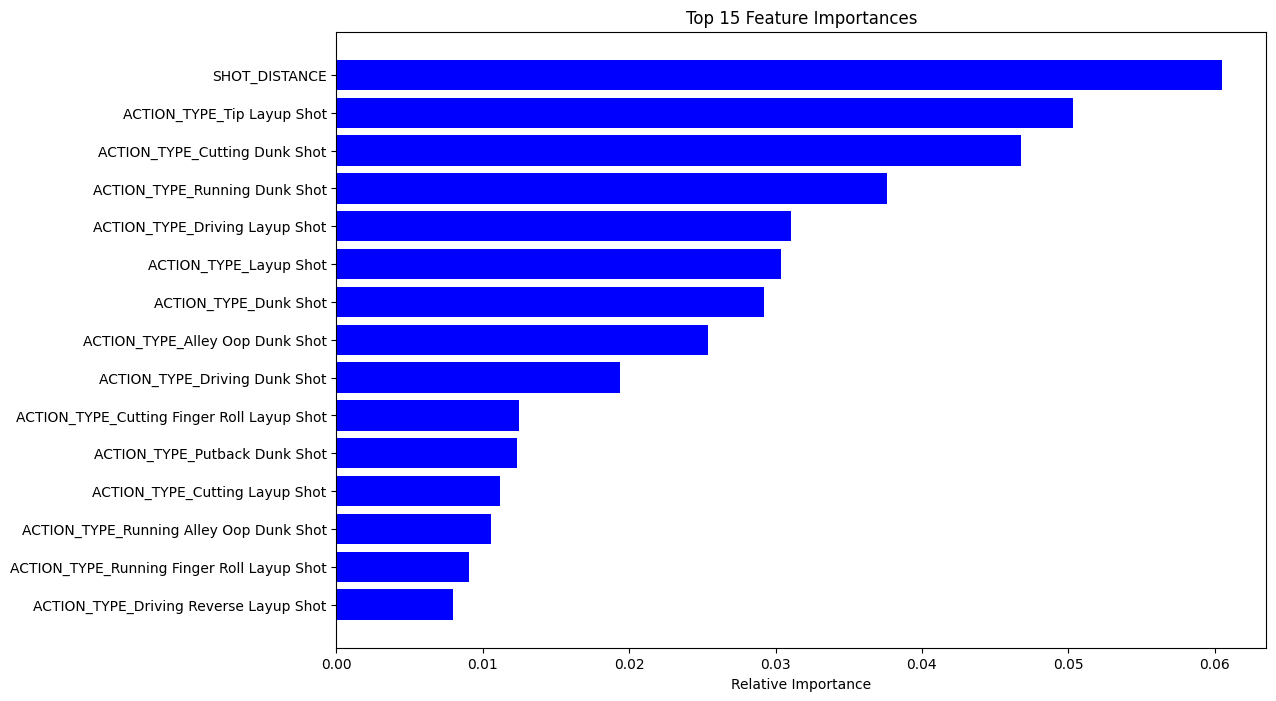

In [512]:
top_features = X.columns[top_indices]
top_importances = importances[top_indices]

# Plotting as a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.title("Top 15 Feature Importances")
plt.barh(range(len(top_indices)), top_importances, align='center', color='blue')
plt.yticks(range(len(top_indices)), top_features, rotation=0)
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

# Hyperparamter Tuning

In [514]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1,3,5]
}​from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1,3,5]
}

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a new model with the best parameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42, **best_params)
best_xgb_model.fit(X_train, y_train)



Best Hyperparameters: 'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.9


# XGBoost with Best Parameters after hyperparamter search 

In [506]:
from sklearn.metrics import roc_auc_score

In [507]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Best hyperparameters from the hyperparameter search
#best_params = {'learning_rate': 0.00001, 'max_depth': 3 , 'min_child_weight':0.00001, 'n_estimators':1}
best_params = {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.9}


# Create an XGBoost classifier with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    seed=42,
    **best_params
)

# Train the model on the training set
best_xgb_model.fit(X_train, y_train)

# Predictions on the validation set
y_val_pred = best_xgb_model.predict(X_val)
y_val_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_val_pred]

# Evaluate the model on the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_binary))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_binary))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_binary))

# Predictions on the test set
y_test_pred = best_xgb_model.predict(X_test)
y_test_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_test_pred]

# Evaluate the model on the test set
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_binary))
print("\nTest AUC ROC score:", roc_auc_score(y_test, y_test_pred_binary))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_binary))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_binary))

Validation Accuracy: 0.6385281912110112

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.85      0.71     87996
           1       0.69      0.40      0.51     76346

    accuracy                           0.64    164342
   macro avg       0.66      0.62      0.61    164342
weighted avg       0.65      0.64      0.62    164342

Confusion Matrix:
 [[74499 13497]
 [45908 30438]]

Test Accuracy: 0.6360069513744542

Test AUC ROC score: 0.6207042236314263

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.84      0.71    109761
           1       0.69      0.40      0.50     95666

    accuracy                           0.64    205427
   macro avg       0.65      0.62      0.61    205427
weighted avg       0.65      0.64      0.62    205427

Confusion Matrix:
 [[92609 17152]
 [57622 38044]]


In [508]:
# Assuming you have already trained your XGBoost model and obtained feature importances
# Replace this with the actual feature importances from your model
feature_importances = best_xgb_model.feature_importances_

# Get the common features between training and test sets
common_features = set(X_train.columns) & set(X_test_2015.columns)

# Create a dictionary to store feature importances
feature_importance_dict = {feature: 0 for feature in X_train.columns}

# Assign the actual importances to common features
for feature, importance in zip(X_train.columns, feature_importances):
    if feature in common_features:
        feature_importance_dict[feature] = importance

# Now, feature_importance_dict contains importances for common features,
# and 0 for features that are in the training set but not in the test set

In [509]:
# Assuming you have already created feature_importance_dict as described in the previous answer

# Get the features with non-zero importance
selected_features = [feature for feature, importance in feature_importance_dict.items() if importance > 0]
# print("Selected Features:", selected_features)
print("Nº of Selected Features:",len(selected_features))
# Filter the training and test sets to include only the selected features
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test_2015[selected_features]

Nº of Selected Features: 205


In [510]:
# Train with early stopping
best_xgb_model.fit(X_train_selected, y_train)
# Predictions
# Predictions on the validation set
y_val_pred = best_xgb_model.predict(X_val_selected)
y_val_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_val_pred]

# Evaluate the model on the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_binary))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_binary))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_binary))

# Predictions on the test set
y_test_pred = best_xgb_model.predict(X_test_selected)
y_test_pred_binary = [1 if prob >= 0.5 else 0 for prob in y_test_pred]

# Evaluate the model on the test set
print("\nTest Accuracy:", accuracy_score(y_test_2015, y_test_pred_binary))
print("\nTest AUC ROC score:", roc_auc_score(y_test_2015, y_test_pred_binary))
print("\nClassification Report:\n", classification_report(y_test_2015, y_test_pred_binary))
print("Confusion Matrix:\n", confusion_matrix(y_test_2015, y_test_pred_binary))

Validation Accuracy: 0.6358447627508489

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.83      0.71     87996
           1       0.68      0.41      0.51     76346

    accuracy                           0.64    164342
   macro avg       0.65      0.62      0.61    164342
weighted avg       0.65      0.64      0.62    164342

Confusion Matrix:
 [[73380 14616]
 [45230 31116]]

Test Accuracy: 0.6360472361221986

Test AUC ROC score: 0.6111330442011415

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.86      0.72    113202
           1       0.67      0.37      0.48     92234

    accuracy                           0.64    205436
   macro avg       0.65      0.61      0.60    205436
weighted avg       0.65      0.64      0.61    205436

Confusion Matrix:
 [[96814 16388]
 [58381 33853]]
